# Exploratory Data Analysis: Lichess database

This jupyter notebook contains an exploratory data analysis done over a chess database with information from 200k games. Each game (the rows of the data frame) contains categorical variates, such as the type of opening (ECO), and numerical variates, such as the elo of each player.

(Tentative) The main objective of this EDA was to determine regularities in the playstyle and how these changed when variates, such as elo, changed. Furthermore, the analysis includes general statistics calculations including location, scale, and shape parameters (mean value, variance, skewness, and kurtosis) which helped draw conclusions from a set of hypothesis tests.

### Remarks

1. In general, the notebook has the following structure: markdown cell --> code cells. 

2. Each code cell includes hashed text explaining briefly what the code is supposed to be doing. Additional commentary is contained in the markdown cells.

3. All the required libraries are included in the first code cell, namely the preamble of the notebook. Exceptions include particular ```scipy``` submodules used for miscellaneous statistics calculations.

4. Recurrent code is included in the ```functions.py``` module.

5. All the pertinent references are in the ```README.md``` file.

6. **All the graphs** contained in this notebook are saved in the ```graphs``` directory.

7. The dataset is available in the github repository as ```modified_dataset```.

In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import functions as f

In [2]:
# Loading dataset
games_df = pd.read_csv('modified_dataset', delimiter = ',')
games_df.drop('index', inplace = True, axis = 1)
games_df

,BlackElo,BlackRatingDiff,Date,ECO,Result,Termination,UTCTime,WhiteElo,WhiteRatingDiff,BlackTitle,WhiteTitle,Category,Weekday,Movements
0,906,13.0,2019.04.30,B15,0-1,Normal,22:00:24,971,-12.0,NaN,NaN,Blitz,Tuesday,73
1,1296,28.0,2019.04.30,C50,0-1,Normal,22:00:13,1312,-10.0,NaN,NaN,Blitz,Tuesday,67
2,1761,-13.0,2019.04.30,C41,1-0,Normal,22:00:41,1653,27.0,NaN,NaN,Rapid,Tuesday,71
3,2404,8.0,2019.04.30,B06,0-1,Normal,22:00:43,2324,-8.0,NaN,FM,Bullet,Tuesday,85
4,1595,-10.0,2019.04.30,B32,1-0,Normal,22:00:46,1614,29.0,NaN,NaN,Blitz,Tuesday,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1491,10.0,2019.05.22,B00,0-1,Normal,21:17:00,1456,-9.0,NaN,NaN,Rapid,Wednesday,30
199996,1549,-10.0,2019.05.22,C21,1-0,Time forfeit,21:17:09,1575,25.0,NaN,NaN,Classical,Wednesday,59
199997,1450,-11.0,2019.05.22,D20,1-0,Normal,21:17:09,1439,11.0,NaN,NaN,Blitz,Wednesday,42
199998,1588,40.0,2019.05.22,B07,0-1,Normal,21:17:13,1753,-18.0,NaN,NaN,Bullet,Wednesday,45


## Goodness of fit test for Elo distribution

$H_0$: Average Elo data is beta distributed.

$H_1$: Average Elo data deviaties from a beta distribution.

In [3]:
from scipy import stats
from functools import partial
from sklearn.utils import resample

avg_elo = (games_df['WhiteElo'] + games_df['BlackElo'])/2 # Calculates average elo of each game
data = avg_elo
re_data = resample(data, replace = True, n_samples = 7500, random_state = 23490) # Resampling
beta_param_bounds = [(4,5),(7,9),(600, 700),(2400,2500)] # Prepares bounds for the a, b, loc, and scale parameters of the beta fit.
fit_result = stats.fit(stats.beta, re_data, beta_param_bounds) # Gives results of the fit
a, b, loc, scale = fit_result.params 
beta_fit = stats.beta(a, b, loc, scale) # Distribution that fits the data best
m, v , s, k = beta_fit.stats(moments = 'mvsk')
print('Mean value: {}'.format(m))
print('Variance: {}'.format(v))
print('Skewness: {}'.format(s))
print('Kurtosis: {}'.format(k))

Mean value: 1512.8657672473623
Variance: 99536.79745296798
Skewness: 0.27235265804532044
Kurtosis: -0.2725759270378833


In [4]:
# Kolmogorov - Smirnov test
D_stat, p_value = stats.kstest(re_data, partial(stats.beta.cdf, a = a, b = b, loc = loc, scale = scale))
print('Maximum function difference (KS test statistic) = {}'.format(D_stat))
print('p value = {}'.format(p_value))
alpha = 0.05
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

Maximum function difference (KS test statistic) = 0.012431079646580023
p value = 0.19513599666372028
The null hypothesis is not rejected.


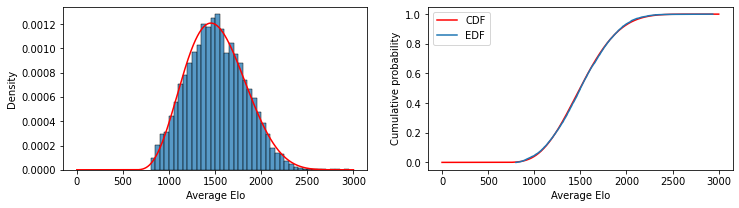

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (12, 3)) # Definition of graphing instances

x = np.linspace(0, 3000, 10000) # Graphing range

pdf = beta_fit.pdf(x) # Probability density function
cdf = beta_fit.cdf(x) # Cumulative distribution function

axes[0].plot(x, pdf, color = 'r', label = 'Fit') # Graphs PDF
sns.histplot(re_data, ax = axes[0], stat = 'density',binwidth = 50, label = 'Data') # Graphs histogram of data

N = 7500 # Number of games
sorted_data = np.sort(re_data) # Ordered data
edf = np.arange(N) / float(N) # 'Experimental' cumulative distribution function

axes[1].plot(x, cdf, color = 'r', label = 'CDF') # Graphs CDF
axes[1].plot(sorted_data, edf, label = 'EDF') # Graphs EDF

for ax in axes.flat:
    ax.set(xlabel = 'Average Elo')

axes[1].set(ylabel = 'Cumulative probability')
plt.legend()
fig.savefig('graphs/kstest-avg_elo', dpi = 700, format = 'pdf', bbox_inches = 'tight')

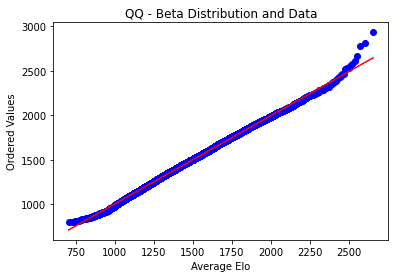

In [6]:
# q-q graph
qq_fig = plt.figure()
ax = qq_fig.add_subplot(111)
stats.probplot(re_data, dist=beta_fit, plot=ax)
ax.set_xlabel('Average Elo')
ax.set_title('QQ - Beta Distribution and Data')
qq_fig.savefig('graphs/qq_avg_elo', dpi = 700, format = 'pdf', bbox_inches = 'tight')

## Goodness of fit test for Elo distribution (Categorical)

As a continuation of the previous test, a $\chi^2$-GOF test is performed over a categorical division of elo, namely: low elo, mid elo, high elo, and very high elo. The fitted distribution is numerically integrated over the required intervals in order to obtain the expected frequencies.

### Intervals

- Low elo if $elo \leq 1400$
- Mid elo if $1400 < elo \leq 1800$
- High elo if $1800 < elo \leq 2000$
- Very high elo if $2000 < elo$

In [7]:
# Elo dataframe (categorical)
elo = pd.DataFrame(avg_elo, columns = ['AverageElo'])
elo['EloTier'] = ['Very high elo' if elo >= 2000 else 'High elo' if elo >= 1800 else \
    'Mid elo' if elo >= 1400 else 'Low elo' for elo in avg_elo]
re_elo = resample(elo, replace = True, n_samples = 7500, random_state = 23490)
re_elo = re_elo.reset_index(drop = True)
re_elo

,AverageElo,EloTier
0,1671.5,Mid elo
1,1909.0,High elo
2,1695.5,Mid elo
3,1202.5,Low elo
4,1420.0,Mid elo
...,...,...
7495,1647.0,Mid elo
7496,1807.5,High elo
7497,1117.5,Low elo
7498,1841.5,High elo


In [8]:
import scipy.integrate as integrate

# Integration
intervals = [(-np.inf, 1400), (1400, 1800), (1800, 2000), (2000, np.inf)]
probabilities_exp = []
for i in intervals:
    probabilities_exp.append(integrate.quad(lambda x: beta_fit.pdf(x), i[0], i[1])[0])

# Counts
observed = re_elo['EloTier'].value_counts(normalize = True)
probabilities_obs = [observed['Low elo'], observed['Mid elo'], observed['High elo'], observed['Very high elo']]

# chi-squared test
chi_stat, p_value = stats.chisquare(probabilities_obs, probabilities_exp)
print('chi statistic = {}'.format(chi_stat))
print('p value = {}'.format(p_value))
alpha = 0.05
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

chi statistic = 0.0013033077787955167
p value = 0.9999874910894104
The null hypothesis is not rejected.


In [9]:
probabilities_exp

[0.38447732572818877,
 0.4278093634514493,
 0.1161592121154271,
 0.07155409885732625]

## ANOVA test: Number of moves and opening

Each game is grouped in one of five categories according to the first letter of ECO.

$H_0$: The mean number of moves for each of the groups is the same.

$H_1$: At least one group has a different mean number of moves.

ECO  Movements
C    44           1345
     52           1331
     47           1330
     46           1324
     50           1322
                  ... 
E    153             1
     154             1
C    198             1
D    196             1
E    19              1
Length: 955, dtype: int64

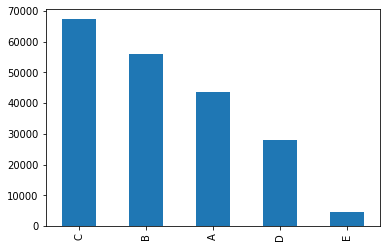

In [10]:
# Creating group dataframe and checking for imbalance
group = pd.DataFrame(games_df['ECO'].str[0])
group['Movements'] = games_df['Movements']
group['ECO'].value_counts().plot.bar()
group.value_counts()

As can be seen from the counts histogram above, the data is imbalanced. In order to correct this, the groups will be downsampled to 1500 observations each.

In [11]:
# Individual dataframes for each group
df_A = group[(group['ECO'] == 'A')]
df_B = group[(group['ECO'] == 'B')]
df_C = group[(group['ECO'] == 'C')]
df_D = group[(group['ECO'] == 'D')]
df_E = group[(group['ECO'] == 'E')]

# Resampling
re_A = resample(df_A, n_samples = 1500, random_state = 23490)
re_B = resample(df_B, n_samples = 1500, random_state = 23490)
re_C = resample(df_C, n_samples = 1500, random_state = 23490)
re_D = resample(df_D, n_samples = 1500, random_state = 23490)
re_E = resample(df_E, n_samples = 1500, random_state = 23490)

# Resampled group dataframe
re_group = pd.concat([re_A, re_B, re_C, re_D, re_E])
re_group = re_group.reset_index(drop = True)
re_group

,ECO,Movements
0,A,62
1,A,65
2,A,48
3,A,43
4,A,43
...,...,...
7495,E,47
7496,E,80
7497,E,66
7498,E,95


<AxesSubplot:xlabel='Movements', ylabel='Density'>

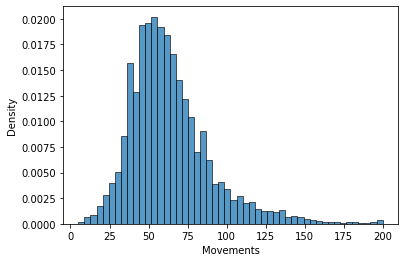

In [12]:
sns.histplot(re_group['Movements'], stat = 'density', bins = 50)

In [13]:
# Grouping
groups = re_group.groupby('ECO').groups
A = re_group['Movements'][groups['A']]
B = re_group['Movements'][groups['B']]
C = re_group['Movements'][groups['C']]
D = re_group['Movements'][groups['D']]
E = re_group['Movements'][groups['E']]

# log transformation
A_log = np.log(A)
B_log = np.log(B)
C_log = np.log(C)
D_log = np.log(D)
E_log = np.log(E)

# ANOVA
f_stat, p_value = stats.f_oneway(A_log, B_log, C_log, D_log, E_log)
print('F statistic = {}'.format(f_stat))
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

F statistic = 21.665848096505243
p-value = 8.532681030482333e-18
The null hypothesis is rejected.


<AxesSubplot:xlabel='Movements', ylabel='Count'>

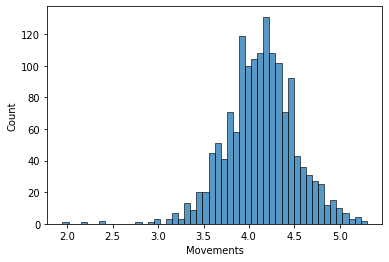

In [14]:
sns.histplot(E_log, bins = 50)

## ANOVA test: Elo and time of the day

Each game is grouped in one of ??? groups according to UTCTime.

$H_0$: The mean elo is the same at any time of the day.

$H_1$: The mean elo is higher for a certain time of the day.

## ANOVA test: Movements and type of game

Each game is grouped in one of 4 types of game according to Category.

$H_0$: The mean number of movements is the same for all the categories.

$H_1$: At least one category has a different mean number of movements.

Blitz        86333
Rapid        45216
Bullet       43253
Classical    25198
Name: Category, dtype: int64

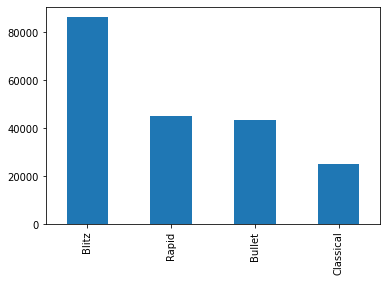

In [15]:
# DataFrame and imbalance
category = games_df[['Movements', 'Category']]
category['Category'].value_counts().plot.bar()
category['Category'].value_counts()

In [16]:
# Individual dataframes for each group
df_blitz = category[(category['Category'] == 'Blitz')]
df_rapid = category[(category['Category'] == 'Rapid')]
df_bullet = category[(category['Category'] == 'Bullet')]
df_classical = category[(category['Category'] == 'Classical')]

# Resampling
re_blitz = resample(df_blitz, n_samples = 1875, random_state = 23490)
re_rapid = resample(df_rapid, n_samples = 1875, random_state = 23490)
re_bullet = resample(df_bullet, n_samples = 1875, random_state = 23490)
re_classical = resample(df_classical, n_samples = 1875, random_state = 23490)

# Resampled group dataframe
re_category = pd.concat([re_blitz, re_rapid, re_bullet, re_classical])
re_category = re_category.reset_index(drop = True)
re_category

,Movements,Category
0,36,Blitz
1,83,Blitz
2,46,Blitz
3,70,Blitz
4,67,Blitz
...,...,...
7495,63,Classical
7496,58,Classical
7497,109,Classical
7498,56,Classical


In [17]:
# Grouping
categories = re_category.groupby('Category').groups
blitz = re_category['Movements'][categories['Blitz']]
rapid = re_category['Movements'][categories['Rapid']]
bullet = re_category['Movements'][categories['Bullet']]
classical = re_category['Movements'][categories['Classical']]

# log transformation
blitz_log = np.log(blitz)
rapid_log = np.log(rapid)
bullet_log = np.log(bullet)
classical_log = np.log(classical)

# ANOVA
f_stat, p_value = stats.f_oneway(blitz_log, rapid_log, bullet_log, classical_log)
print('F statistic = {}'.format(f_stat))
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

F statistic = 7.779036975023016
p-value = 3.4926029268274264e-05
The null hypothesis is rejected.


<AxesSubplot:xlabel='Movements', ylabel='Count'>

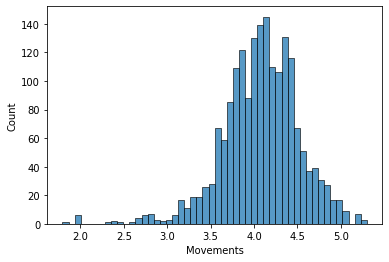

In [18]:
sns.histplot(rapid_log, bins = 50)

## Statistical independence: Elo range and Opening

A $\chi ^ 2$-test is used to determine if the categorical variates EloTier and ECO are statistically independent.

$H_0$: The variates are independent.

$H_1$: The variates are dependent.

In [19]:
group['EloTier'] = elo['EloTier']
elo_op = group.drop('Movements', axis = 1)

# Individual dataframes for each group
df_low = elo_op[(elo_op['EloTier'] == 'Low elo')]
df_mid = elo_op[(elo_op['EloTier'] == 'Mid elo')]
df_high = elo_op[(elo_op['EloTier'] == 'High elo')]
df_vhigh = elo_op[(elo_op['EloTier'] == 'Very high elo')]

# Resampling
re_low = resample(df_low, n_samples = 1500, random_state = 23490)
re_mid = resample(df_mid, n_samples = 1500, random_state = 23490)
re_high = resample(df_high, n_samples = 1500, random_state = 23490)
re_vhigh = resample(df_vhigh, n_samples = 1500, random_state = 23490)

# Resampled dataframe
re_elo_op = pd.concat([re_low, re_mid, re_high, re_vhigh])
re_elo_op = re_elo_op.reset_index(drop = True)

# Contingency table
ct_ind = pd.crosstab(re_elo_op['ECO'], re_elo_op['EloTier'])
print(ct_ind)

EloTier  High elo  Low elo  Mid elo  Very high elo
ECO                                               
A             373      297      346            464
B             492      348      427            502
C             340      594      513            263
D             237      246      183            198
E              58       15       31             73


In [20]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(ct_ind)
print('chi2 statistic = {}'.format(chi2_stat))
print('p-value = {}'.format(p_value))
print('# degrees of freedom = {}'.format(dof))

if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

chi2 statistic = 296.3056073976459
p-value = 2.8004547989071422e-56
# degrees of freedom = 12
The null hypothesis is rejected.


## ANOVA test: Win rate and Elo range

Each game is classified in one of 4 tiers of elo according to the mean elo between black and white: low elo, mid elo, high elo, very high elo.

$H_0$: The mean win rate is the same for each elo tier.

$H_1$: The mean win rate of at least one tier is different.

## Is there correlation between Termination and RatingDiff?

## Is there correlation between Result and RatingDiff?